In [2]:
import itertools
import os
import pickle
import sys
from pathlib import Path

import cv2
import hdbscan
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import phenograph
import seaborn as sns
import skimage.io
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import DBSCAN, OPTICS, KMeans, cluster_optics_dbscan
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from skimage import measure

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
# Import path
module_path = str(Path.cwd().parents[0])
if module_path not in sys.path:
    sys.path.append(module_path)

In [5]:
from config import *

# Read data

In [6]:
pixel_features = data_meta / 'pixel_intensity.csv'

df = pd.read_csv(pixel_features)

In [7]:
pixels = df.iloc[:,:11]

In [8]:
pixels.max()

DAPI                     24117
Phalloidin               61307
WGA                      57667
Concanavadin A           59602
APC                      61245
Cyclin D1                34600
Cyclin E                 54336
EMMPRIN                  60834
WNT-1                    64637
Non-phospho-B-catenin    28759
DKK1                      6677
dtype: int64

In [9]:
# Scale data
scaler = MinMaxScaler()
x_scaled = scaler.fit_transform(pixels)
pixels_scaled = pd.DataFrame(x_scaled, columns=pixels.columns)

In [10]:
pixels_scaled.describe()

,DAPI,Phalloidin,WGA,Concanavadin A,APC,Cyclin D1,Cyclin E,EMMPRIN,WNT-1,Non-phospho-B-catenin,DKK1
count,4.189708e+06,4.189708e+06,4.189708e+06,4.189708e+06,4.189708e+06,4.189708e+06,4.189708e+06,4.189708e+06,4.189708e+06,4.189708e+06,4.189708e+06
mean,5.490950e-02,4.898193e-02,3.293212e-02,4.402110e-02,7.236760e-03,3.255747e-03,1.000895e-02,5.946675e-03,2.468510e-03,2.045527e-02,1.816867e-02
std,1.399681e-01,4.085330e-02,6.341810e-02,9.892625e-02,1.461627e-02,2.681191e-03,2.095746e-02,1.533676e-02,6.028638e-03,2.209952e-02,1.103692e-02
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,0.000000e+00,2.386085e-02,0.000000e+00,0.000000e+00,1.730754e-03,1.820809e-03,6.257362e-04,1.479436e-03,3.248913e-04,5.737334e-03,1.078329e-02
50%,0.000000e+00,3.779888e-02,4.075121e-03,0.000000e+00,4.702425e-03,3.005780e-03,5.061101e-03,4.043791e-03,1.345978e-03,1.404778e-02,1.722330e-02
75%,0.000000e+00,6.006352e-02,3.678013e-02,4.766619e-02,8.686423e-03,4.335260e-03,1.153931e-02,7.446494e-03,2.722899e-03,2.555722e-02,2.426239e-02
max,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00


In [11]:
pixel_dark = pixels_scaled.le(0.3).all(axis=1)

pixel_dark.value_counts()

True     3653056
False     536652
dtype: int64

In [12]:
pixels_bright = pixels_scaled[~pixel_dark]

In [13]:
pixels_bright

,DAPI,Phalloidin,WGA,Concanavadin A,APC,Cyclin D1,Cyclin E,EMMPRIN,WNT-1,Non-phospho-B-catenin,DKK1
84,0.000000,0.042620,0.178248,0.323412,0.000098,0.008439,0.005411,0.004636,0.005229,0.005807,0.010034
85,0.000000,0.040777,0.193889,0.335928,0.007641,0.001156,0.015312,0.000444,0.006977,0.000000,0.023064
86,0.000000,0.041370,0.204103,0.367488,0.009650,0.000000,0.010730,0.000756,0.005415,0.011162,0.029954
87,0.000000,0.050618,0.213970,0.418879,0.007494,0.006705,0.011466,0.001792,0.005399,0.003686,0.022016
88,0.000000,0.043213,0.202178,0.405523,0.004213,0.003150,0.021625,0.005573,0.006281,0.000000,0.024113
...,...,...,...,...,...,...,...,...,...,...,...
4189270,0.391923,0.039856,0.069537,0.064025,0.006694,0.003064,0.017631,0.004767,0.001686,0.029521,0.023813
4189271,0.369076,0.035758,0.028873,0.066944,0.005943,0.003295,0.016821,0.009501,0.002383,0.031468,0.004044
4189272,0.364598,0.028748,0.018485,0.064025,0.015740,0.002023,0.014999,0.007216,0.000897,0.051740,0.017822
4189273,0.340175,0.027761,0.011670,0.067414,0.026304,0.003150,0.016711,0.003436,0.002630,0.048402,0.020818


In [14]:
pca = PCA(n_components=3)
pca.fit(pixels_bright)
print(pca.explained_variance_ratio_)

[0.66195785 0.17144699 0.08396744]


In [15]:
X = pca.transform(pixels_bright)

# Clustering

## KMeans

In [16]:
# from yellowbrick.cluster import KElbowVisualizer

# model = KMeans()
# visualizer = KElbowVisualizer(model, k=(4,12), timings=False)

# visualizer.fit(X)        # Fit the data to the visualizer
# visualizer.show()

In [17]:
# k_means = KMeans(n_clusters=6)
# k_means.fit(X)
# labels = k_means.labels_

# fig = plt.figure(figsize=(10, 10))
# ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)

# ax.scatter(X[:, 0], X[:, 1], X[:, 2],
#                c=labels.astype(np.float), edgecolor='k')

# ax.w_xaxis.set_ticklabels([])
# ax.w_yaxis.set_ticklabels([])
# ax.w_zaxis.set_ticklabels([])
# ax.set_title('PCA')
# ax.dist = 12

## HDBSCAN

In [18]:
clusterer = hdbscan.HDBSCAN(min_cluster_size=100, prediction_data=True)
clusterer.fit(X)

HDBSCAN(min_cluster_size=100, prediction_data=True)

In [19]:
np.unique(clusterer.labels_, return_counts=True)

(array([-1,  0,  1,  2,  3,  4,  5,  6,  7], dtype=int64),
 array([ 62379,    152,    442, 388342,   4749,   1656,    281,   1068,
         77583], dtype=int64))

In [20]:
soft_clusters = hdbscan.all_points_membership_vectors(clusterer)

In [21]:
soft_labels = [np.argmax(x) for x in soft_clusters]
np.unique(soft_labels, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7], dtype=int64),
 array([   666,   7452, 410101,   8119,   2234,   3602,   8045,  96433],
       dtype=int64))

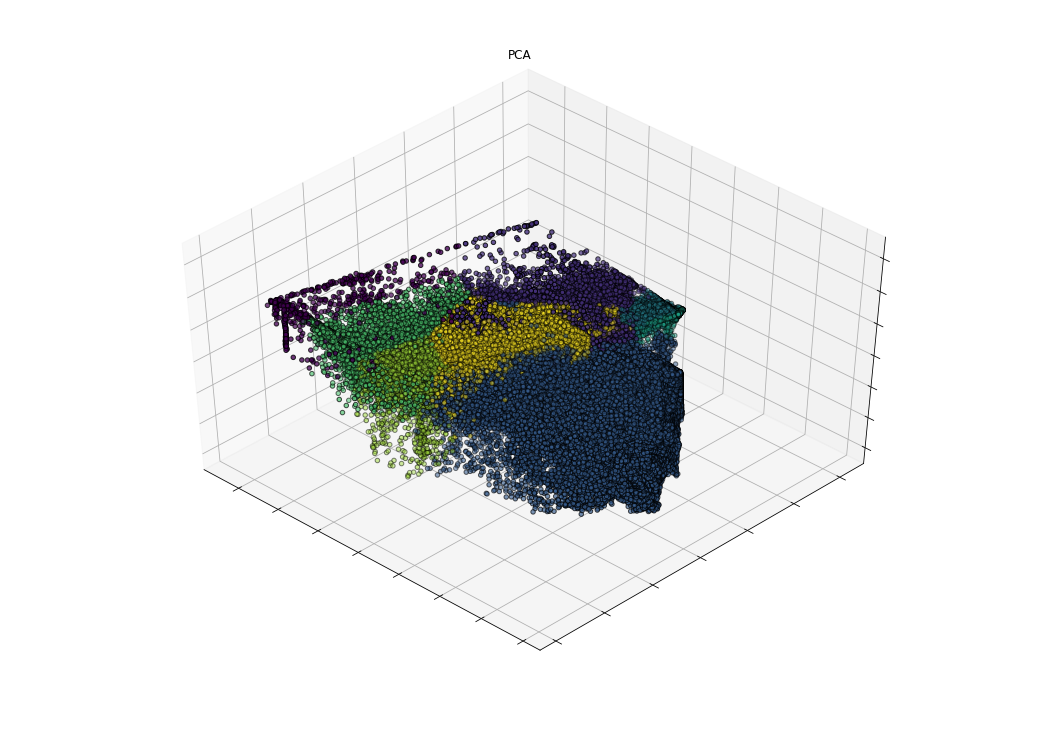

In [22]:
fig = plt.figure(figsize=(15, 10))
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)

ax.scatter(X[:, 0], X[:, 1], X[:, 2],
               c=np.array(soft_labels).astype(np.float), edgecolor='k')

ax.w_xaxis.set_ticklabels([])
ax.w_yaxis.set_ticklabels([])
ax.w_zaxis.set_ticklabels([])
ax.set_title('PCA')
ax.dist = 12

In [23]:
pixels_bright.loc[:,'label'] = np.array(soft_labels) + 1

C:\Users\thu71\.conda\envs\Thomas\lib\site-packages\pandas\core\indexing.py:845: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\thu71\.conda\envs\Thomas\lib\site-packages\pandas\core\indexing.py:1048: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item_labels[indexer[info_axis]]] = value


# Phenograph

In [24]:
# k = 30 # choose k
# communities, graph, Q = phenograph.cluster(X,k=k)

In [25]:
# # define a function that will give us the relevant output for the input k
# def calc_cluster_characteristics(k, PCA):
#     results = pd.Series(dtype = 'float64')
#     results['k'] = k
#     results['communities'], results['graph'], results['Q'] = phenograph.cluster(PCA, k=k)
#     results['components'], _ = sparse.csgraph.connected_components(results['graph'], directed = False)
#     return results

# ks = np.arange(5, 40, 5)  # This is the range of k values we will look at
# cluster_chars_list = [calc_cluster_characteristics(k, X) for k in ks]
# cluster_characteristics = pd.concat(cluster_chars_list, axis = 1).transpose()

In [26]:
# k = cluster_characteristics['k']
# no_components = cluster_characteristics['components']
# Q = cluster_characteristics['Q']

# fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(14, 5))
# ax1.set_box_aspect(1)
# ax1.plot(k, no_components, color='k', marker='o', linestyle='dashed', linewidth=1, markersize=5, )
# ax1.set_xlabel('k')
# ax1.set_ylabel('No. Components')
# ax1.set_ylim(0, 15)

# ax2.set_box_aspect(1)
# ax2.plot(k, Q, color='k', marker='o', linestyle='dashed', linewidth=1, markersize=5)
# ax2.set_xlabel('k')
# ax2.set_ylabel('Q Modularity Score')
# ax2.set_ylim(0, 1)

# plt.show()
# plt.close()

# Visualization


## Cluster visualization of markers expression

In [27]:
df_per_label = pixels_bright.groupby('label').mean()
df_per_label

,DAPI,Phalloidin,WGA,Concanavadin A,APC,Cyclin D1,Cyclin E,EMMPRIN,WNT-1,Non-phospho-B-catenin,DKK1
label,,,,,,,,,,,
1,0.066183,0.114567,0.891363,0.769738,0.016089,0.005547,0.026183,0.017621,0.009141,0.042449,0.028800
2,0.178709,0.088560,0.454079,0.109249,0.011694,0.004049,0.024098,0.013651,0.002914,0.048296,0.020521
3,0.431752,0.042751,0.119150,0.114445,0.009840,0.003377,0.030085,0.011298,0.001270,0.069015,0.019030
4,0.001207,0.293155,0.028395,0.035758,0.029392,0.003434,0.064930,0.027090,0.003798,0.016848,0.019247
5,0.003827,0.040606,0.003173,0.014430,0.129510,0.005118,0.149411,0.265544,0.038173,0.028137,0.020916
6,0.051805,0.126919,0.518730,0.783433,0.017083,0.005518,0.026263,0.014480,0.006593,0.042666,0.032267
7,0.045388,0.073547,0.242005,0.840981,0.019438,0.005806,0.031359,0.013962,0.008581,0.039048,0.035366
8,0.016480,0.079679,0.150352,0.433817,0.018504,0.004806,0.030856,0.010518,0.008367,0.026865,0.030012


[Text(0.5, 0, 'DAPI'),
 Text(1.5, 0, 'Phalloidin'),
 Text(2.5, 0, 'WGA'),
 Text(3.5, 0, 'Concanavadin A'),
 Text(4.5, 0, 'APC'),
 Text(5.5, 0, 'Cyclin D1'),
 Text(6.5, 0, 'Cyclin E'),
 Text(7.5, 0, 'EMMPRIN'),
 Text(8.5, 0, 'WNT-1'),
 Text(9.5, 0, 'Non-phospho-B-catenin'),
 Text(10.5, 0, 'DKK1')]

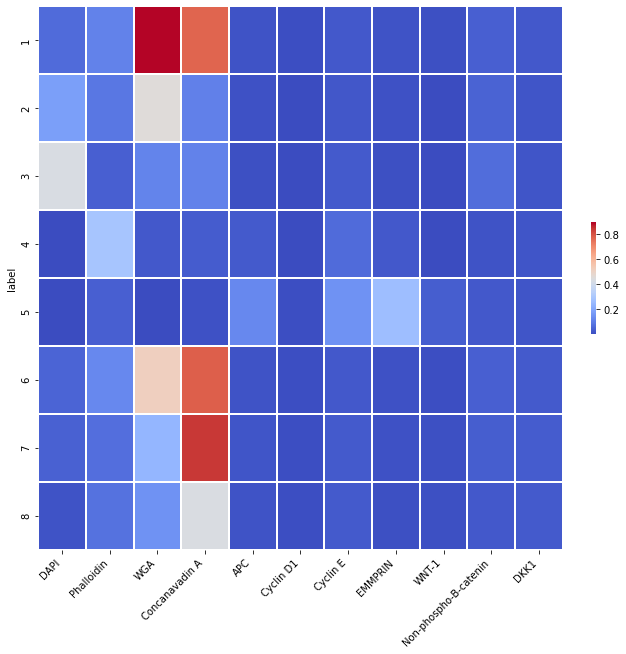

In [28]:
fig, ax = plt.subplots(figsize=(10,10))
ax = sns.heatmap(df_per_label, cbar_kws={'fraction' : 0.01}, linewidth=1, cmap="coolwarm")
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')


## Pixel location visualization

First we add back the location and condition information in the pixel_bright dataframe

In [29]:
pixels_bright = pixels_bright.join(df.iloc[:,11:])
pixels_bright

,DAPI,Phalloidin,WGA,Concanavadin A,APC,Cyclin D1,Cyclin E,EMMPRIN,WNT-1,Non-phospho-B-catenin,DKK1,label,Condition,X,Y,Id
84,0.000000,0.042620,0.178248,0.323412,0.000098,0.008439,0.005411,0.004636,0.005229,0.005807,0.010034,8,Fw1,0,612,4
85,0.000000,0.040777,0.193889,0.335928,0.007641,0.001156,0.015312,0.000444,0.006977,0.000000,0.023064,8,Fw1,0,613,4
86,0.000000,0.041370,0.204103,0.367488,0.009650,0.000000,0.010730,0.000756,0.005415,0.011162,0.029954,8,Fw1,0,614,4
87,0.000000,0.050618,0.213970,0.418879,0.007494,0.006705,0.011466,0.001792,0.005399,0.003686,0.022016,8,Fw1,0,615,4
88,0.000000,0.043213,0.202178,0.405523,0.004213,0.003150,0.021625,0.005573,0.006281,0.000000,0.024113,8,Fw1,0,616,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4189270,0.391923,0.039856,0.069537,0.064025,0.006694,0.003064,0.017631,0.004767,0.001686,0.029521,0.023813,3,Fw3,1413,976,32
4189271,0.369076,0.035758,0.028873,0.066944,0.005943,0.003295,0.016821,0.009501,0.002383,0.031468,0.004044,3,Fw3,1413,977,32
4189272,0.364598,0.028748,0.018485,0.064025,0.015740,0.002023,0.014999,0.007216,0.000897,0.051740,0.017822,3,Fw3,1413,978,32
4189273,0.340175,0.027761,0.011670,0.067414,0.026304,0.003150,0.016711,0.003436,0.002630,0.048402,0.020818,3,Fw3,1413,979,32


In [30]:
condition = 'Fw1'

df_subset = pixels_bright[pixels_bright.Condition == condition]
df_subset

,DAPI,Phalloidin,WGA,Concanavadin A,APC,Cyclin D1,Cyclin E,EMMPRIN,WNT-1,Non-phospho-B-catenin,DKK1,label,Condition,X,Y,Id
84,0.000000,0.042620,0.178248,0.323412,0.000098,0.008439,0.005411,0.004636,0.005229,0.005807,0.010034,8,Fw1,0,612,4
85,0.000000,0.040777,0.193889,0.335928,0.007641,0.001156,0.015312,0.000444,0.006977,0.000000,0.023064,8,Fw1,0,613,4
86,0.000000,0.041370,0.204103,0.367488,0.009650,0.000000,0.010730,0.000756,0.005415,0.011162,0.029954,8,Fw1,0,614,4
87,0.000000,0.050618,0.213970,0.418879,0.007494,0.006705,0.011466,0.001792,0.005399,0.003686,0.022016,8,Fw1,0,615,4
88,0.000000,0.043213,0.202178,0.405523,0.004213,0.003150,0.021625,0.005573,0.006281,0.000000,0.024113,8,Fw1,0,616,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1434805,0.476179,0.030460,0.032688,0.109074,0.000000,0.004566,0.013840,0.005310,0.000541,0.032546,0.022166,3,Fw1,1415,1864,35
1434806,0.455446,0.029999,0.045745,0.112681,0.001633,0.001792,0.012993,0.004734,0.000449,0.030877,0.017673,3,Fw1,1415,1865,35
1434807,0.440602,0.033767,0.042988,0.130247,0.001176,0.001185,0.013030,0.000000,0.000000,0.025349,0.001797,3,Fw1,1415,1866,35
1434808,0.442427,0.034031,0.049023,0.145683,0.000000,0.001908,0.021459,0.000000,0.000000,0.041448,0.012730,3,Fw1,1415,1867,35


In [31]:
# Read mask image
def get_masks(mask_folder):
    '''
    Function to get all mask from mask forlder
    '''
    # Read masks
    masks = {}

    for (dirpath, dirnames, filenames) in os.walk(mask_folder):
        for name in sorted(filenames):
            if "tiff" in name:
                condition = name.split("_")[0]
                masks[condition] = masks.get(condition, {})
                filename = os.path.join(dirpath, name)
            if "cyto" in name:
                img = skimage.io.imread(filename)
                masks[condition]["cyto"] = img
            elif "nuclei" in name:
                img = skimage.io.imread(filename)
                masks[condition]["nuclei"] = img
    return masks

def qc_nuclei(mask_cyto, mask_nuclei):
    '''
    Function to check if cell masks contain nuclei
    '''
    cell = np.zeros((mask_cyto.shape), dtype=np.uint8)
    nuclei = np.zeros((mask_cyto.shape), dtype=np.uint8)
    cyto = np.zeros((mask_cyto.shape), dtype=np.uint8)

    for label in range(1, mask_cyto.max()):
        # Check if cell has nuclei
        cell_mask = np.where(mask_cyto == label, 1, 0).astype(np.uint8)
        maski = cv2.bitwise_and(mask_nuclei, mask_nuclei, mask=cell_mask)

        # If no nuclei detected then pass
        if maski.max() == 0:
            continue

        # Link label accross cell, nuclei, cyto
        cell = np.where(mask_cyto == label, label, cell)
        nuclei = np.where(maski > 0, label, nuclei)
        maski = cv2.subtract(cell_mask, maski)
        cyto = np.where(maski > 0, label, cyto)
    return cell, nuclei, cyto

masks = get_masks(data_mask)
mask,_, _ = qc_nuclei(masks[condition]['cyto'], masks[condition]['nuclei'])

In [32]:
# Create image from pixel location 
x_max, y_max = mask.shape

x = df_subset.X.tolist()
y = df_subset.Y.tolist()
values = df_subset.label.tolist()

img = np.zeros((x_max, y_max))
img[x, y] = values

In [33]:
# Get contour of masks
contours = {}
labels = [n for n in np.unique(mask) if n > 0]
for i in labels:
    temp = np.where(mask == i, mask, 0)
    contours[i] = measure.find_contours(temp, 0.1)[0]

(-0.5, 1874.5, 1415.5, -0.5)

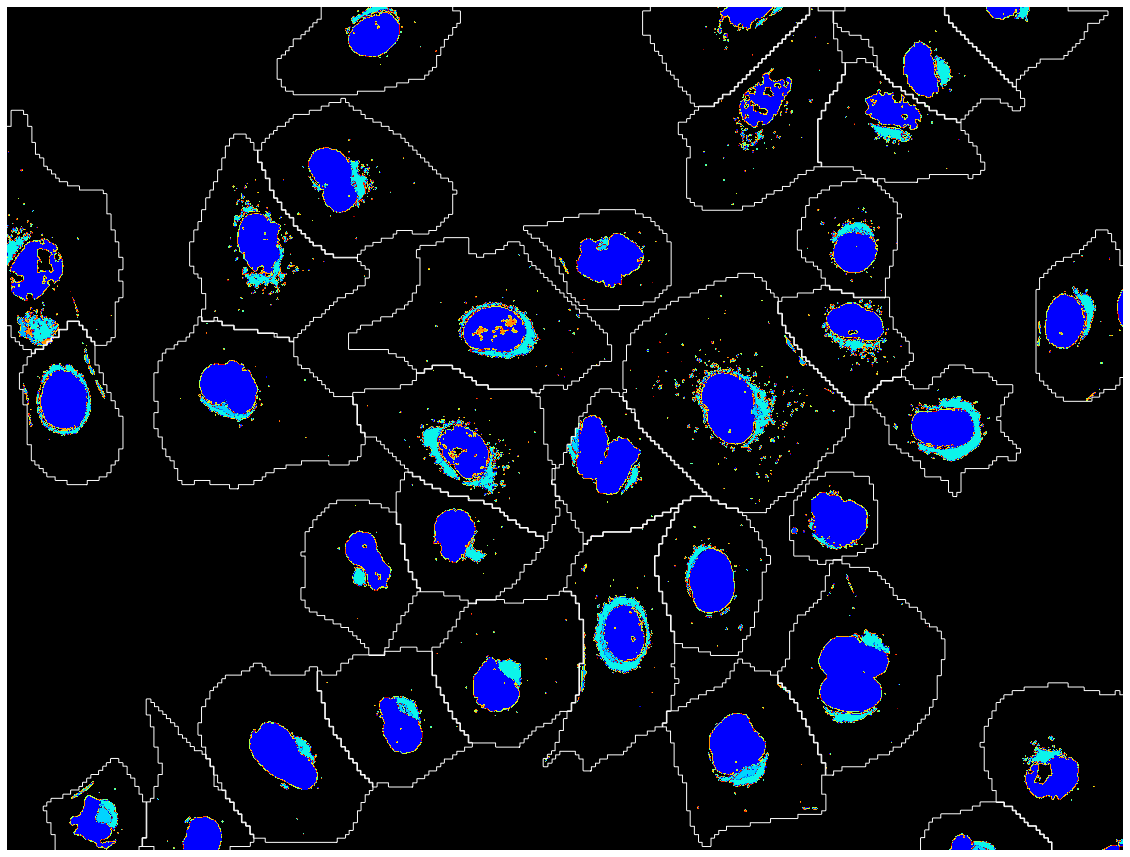

In [34]:
# Get random colormap
vals = np.linspace(0,1,len(labels))
np.random.seed(1)
np.random.shuffle(vals)
black = np.array([[0,0,0,1]])
colors = np.concatenate((black, plt.cm.jet(vals)))
my_cmap = plt.cm.colors.ListedColormap(colors)

# Show contour
fig, ax = plt.subplots(figsize=(20,20))
ax.imshow(img, cmap=my_cmap)
for label, contour in contours.items():
    ax.plot(contour[:, 1], contour[:, 0], linewidth=1, c='w')
ax.axis('off')